In [126]:
import pandas as pd

# Caminho do arquivo
file_path = "blip-tags-metric-report.csv"

# Carregar o dataset
df = pd.read_csv(file_path)

# Exibir as primeiras 5 linhas do dataset
df_head = df.head()

# Obter número de linhas e colunas
num_linhas, num_colunas = df.shape

# Obter informações sobre o dataset
df_info = df.info()

# Exibir os resultados
df_head, num_linhas, num_colunas


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Tag                         188 non-null    object
 1   Tickets finalizados         188 non-null    int64 
 2   Tempo médio da 1ª resposta  188 non-null    object
 3   Tempo médio de espera       188 non-null    object
 4   Tempo médio de resposta     188 non-null    object
 5   Tempo médio de atendimento  188 non-null    object
dtypes: int64(1), object(5)
memory usage: 8.9+ KB


(                                                 Tag  Tickets finalizados  \
 0                Tentativa - Sem Sucesso/Inatividade                11094   
 1   Tentativa - Sem sucesso/Visualiza a mensagem ...                 4398   
 2   Confirmado - Já está no Processo Seletivo/Mat...                 2061   
 3   Tentativa - Sem sucesso/Aguardando resposta n...                 1325   
 4                   Confirmado - Inscrição realizada                 1223   
 
   Tempo médio da 1ª resposta Tempo médio de espera Tempo médio de resposta  \
 0                   00:01:47              00:50:02                00:03:46   
 1                   00:01:36              01:34:17                00:03:29   
 2                   00:01:38              00:13:25                00:02:54   
 3                   00:01:48              00:55:07                00:03:10   
 4                   00:01:30              00:15:14                00:02:25   
 
   Tempo médio de atendimento  
 0                   0

In [127]:
# Standardizing the 'Tag' column

# Removing extra spaces, converting to lowercase, and replacing special characters
df['Tag'] = df['Tag'].str.strip().str.lower()

# Replacing similar names to unify categories
replacements = {
    "inscrição realizada": "confirmado - inscrição realizada",
    "inscrição realizada ": "confirmado - inscrição realizada",
    "tentativa - sem sucesso/inatividade": "tentativa - sem sucesso",
    "tentativa - sem sucesso/visualiza a mensagem e não responde": "tentativa - sem sucesso",
    "tentativa - sem sucesso/aguardando resposta na conversa": "tentativa - sem sucesso",
    "confirmado - já está no processo seletivo/matriculado": "confirmado - processo seletivo"
}

df['Tag'] = df['Tag'].replace(replacements)

# Checking the unique values after standardization
unique_tags = df['Tag'].unique()

# Displaying the cleaned unique tags
unique_tags


array(['tentativa - sem sucesso', 'confirmado - processo seletivo',
       'tentativa - sem sucesso/aguardando resposta no whatsapp',
       'confirmado - inscrição realizada',
       'analisando - analisando grade curricular/informações sobre o curso',
       'desqualificado - já é nosso aluno/assuntos acadêmicos',
       'analisando - aguardando resposta no whatsapp',
       'analisando - financeiro/verificando valores',
       'confirmado - entrega de documentação/via portal',
       'confirmado - promessa de pagamento/boleto enviado',
       'confirmado - entrega de documentação/via contact center',
       'desqualificado - já é nosso aluno/assuntos financeiros',
       'analisando - aguardando/dúvidas sobre prouni/fies',
       'desqualificado - engano/não era nosso cliente',
       'confirmado - recuperação de senha/acesso ao portal',
       'analisando - vai visitar unidade/entrar em contato com a unidade',
       'desistente - não tem interesse na modalidade disponível',
      

In [128]:
# Standardizing column names

# Removing extra spaces, converting to lowercase, and replacing special characters
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_").str.replace("ã", "a").str.replace("ç", "c")

# Checking the updated column names
df.columns


Index(['tag', 'tickets_finalizados', 'tempo_médio_da_1ª_resposta',
       'tempo_médio_de_espera', 'tempo_médio_de_resposta',
       'tempo_médio_de_atendimento'],
      dtype='object')

In [129]:
# Checking for missing values in the dataset
missing_values = df.isnull().sum()

# Creating a dataframe to display missing values count per column
missing_values_df = pd.DataFrame(missing_values, columns=['Valores Ausentes'])

In [130]:
# Replacing "-" with "00:00:00" in time-related columns
time_columns = ["tempo_médio_da_1ª_resposta", "tempo_médio_de_espera", "tempo_médio_de_resposta", "tempo_médio_de_atendimento"]

for col in time_columns:
    df[col] = df[col].replace("-", "00:00:00")

In [131]:
# Function to convert time format HH:MM:SS to total seconds
def time_to_seconds(time_str):
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

# Applying the conversion to all time-related columns
for col in time_columns:
    df[col] = df[col].apply(time_to_seconds)


In [133]:
# Removendo as linhas onde todas as métricas relevantes são zero
df_cleaned = df[(df['tickets_finalizados'] > 0) |
                (df['tempo_médio_da_1ª_resposta'] > 0) |
                (df['tempo_médio_de_espera'] > 0) |
                (df['tempo_médio_de_resposta'] > 0) |
                (df['tempo_médio_de_atendimento'] > 0)].copy()


In [134]:
# Extracting the category name before the first " - " in each tag
df['categoria'] = df['tag'].apply(lambda x: x.split(" - ")[0])

# Counting the occurrences of each category
category_counts = df['categoria'].value_counts().reset_index()
category_counts.columns = ['categoria', 'quantidade']

category_counts


,categoria,quantidade
0,desistente,56
1,confirmado,41
2,analisando,32
3,desqualificado,31
4,tentativa,19
5,analisando – localização,2
6,analisando – campus,2
7,desqualificado – teste,2
8,desqualificado – falecido,2
9,add,1


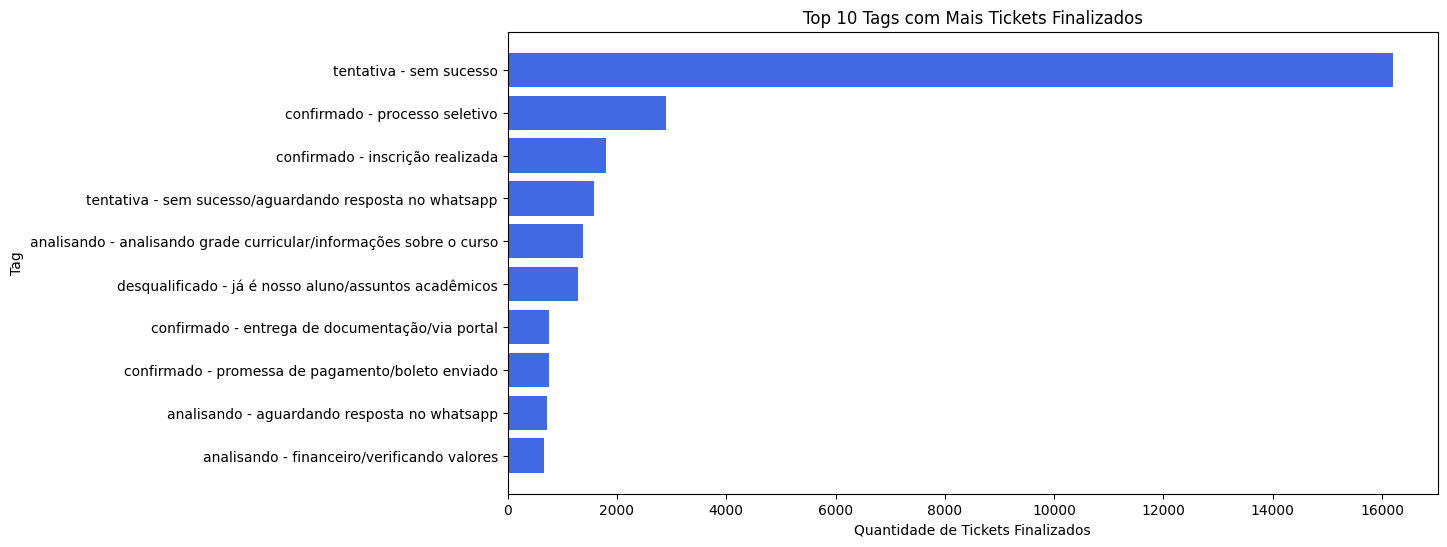

In [135]:
import matplotlib.pyplot as plt

# Contando os tickets finalizados por tag e selecionando as 10 mais frequentes
top_tags = df.groupby('tag')['tickets_finalizados'].sum().nlargest(10).reset_index()

# Plotando o gráfico de barras
plt.figure(figsize=(12, 6))
plt.barh(top_tags['tag'], top_tags['tickets_finalizados'], color='royalblue')
plt.xlabel("Quantidade de Tickets Finalizados")
plt.ylabel("Tag")
plt.title("Top 10 Tags com Mais Tickets Finalizados")
plt.gca().invert_yaxis()  # Inverter a ordem para a tag mais frequente ficar no topo
plt.show()



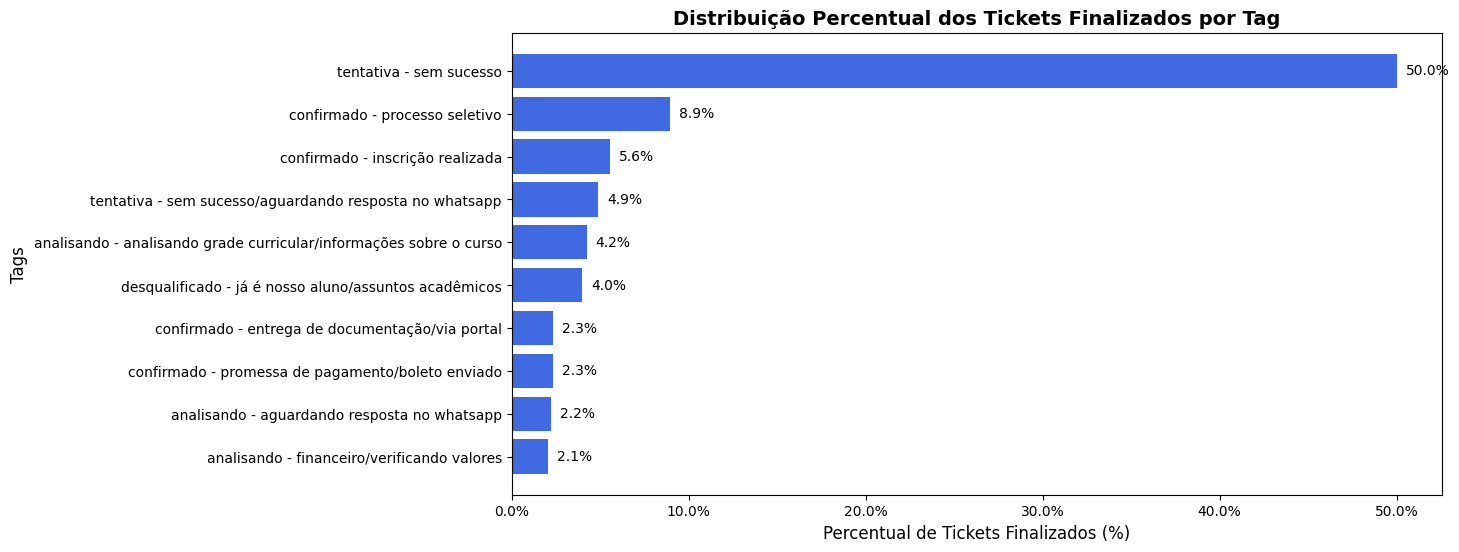

In [136]:
# Recalculando a distribuição percentual dos tickets finalizados por tag
df_tickets = df.groupby('tag')['tickets_finalizados'].sum().reset_index()
df_tickets['percentual'] = (df_tickets['tickets_finalizados'] / df_tickets['tickets_finalizados'].sum()) * 100

# Selecionando as principais categorias (as 10 maiores)
top_tags_percentual = df_tickets.nlargest(10, 'tickets_finalizados')

# Criando o gráfico de barras horizontais com rótulos de valores exatos

fig, ax = plt.subplots(figsize=(12, 6))

# Criando o gráfico de barras horizontais
bars = ax.barh(top_tags_percentual['tag'], top_tags_percentual['percentual'], color='royalblue')

# Adicionando os valores exatos ao lado de cada barra
for bar, value in zip(bars, top_tags_percentual['percentual']):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f"{value:.1f}%", va='center', fontsize=10)

# Adicionando rótulos e título
ax.set_xlabel("Percentual de Tickets Finalizados (%)", fontsize=12)
ax.set_ylabel("Tags", fontsize=12)
ax.set_title("Distribuição Percentual dos Tickets Finalizados por Tag", fontsize=14, fontweight='bold')

# Ajustando a formatação do eixo X
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1f}%"))

# Revertendo a ordem das tags para a mais relevante aparecer no topo
ax.invert_yaxis()

# Exibir o gráfico aprimorado
plt.show()


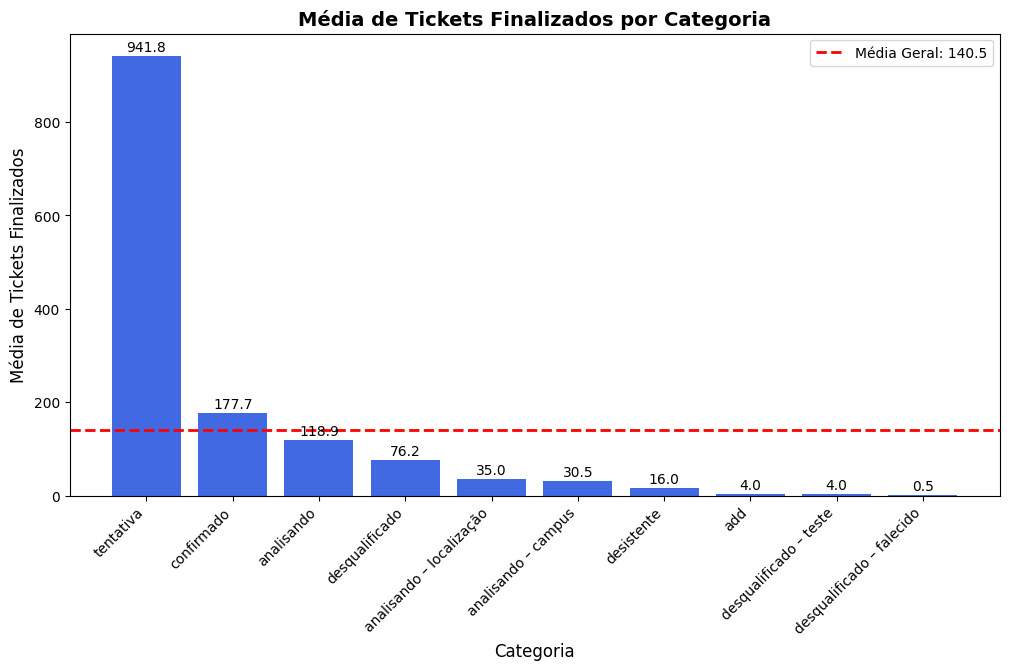

In [137]:
# Agrupando os tickets finalizados por categoria geral
category_avg_tickets = df.groupby('categoria')['tickets_finalizados'].mean().reset_index()

# Ordenando pela média de tickets finalizados
category_avg_tickets = category_avg_tickets.sort_values(by='tickets_finalizados', ascending=False)

# Calculando a média geral de tickets finalizados
overall_avg_tickets = category_avg_tickets['tickets_finalizados'].mean()

# Criando o gráfico de barras comparando as categorias com a média geral
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(category_avg_tickets['categoria'], category_avg_tickets['tickets_finalizados'], color='royalblue')

# Adicionando a linha da média geral
ax.axhline(overall_avg_tickets, color='red', linestyle='dashed', linewidth=2, label=f"Média Geral: {overall_avg_tickets:.1f}")

# Adicionando os valores exatos no topo das barras
for bar, value in zip(bars, category_avg_tickets['tickets_finalizados']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10, f"{value:.1f}", ha='center', fontsize=10)

# Ajustando rótulos e título
ax.set_xlabel("Categoria", fontsize=12)
ax.set_ylabel("Média de Tickets Finalizados", fontsize=12)
ax.set_title("Média de Tickets Finalizados por Categoria", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha="right")

# Adicionando a legenda
ax.legend()

# Exibir o gráfico aprimorado
plt.show()

# Exibir a tabela com os valores médios de tickets por categoria incluindo a média geral
category_avg_tickets.loc[len(category_avg_tickets.index)] = ['Média Geral', overall_avg_tickets]  # Adicionando a média geral à tabela

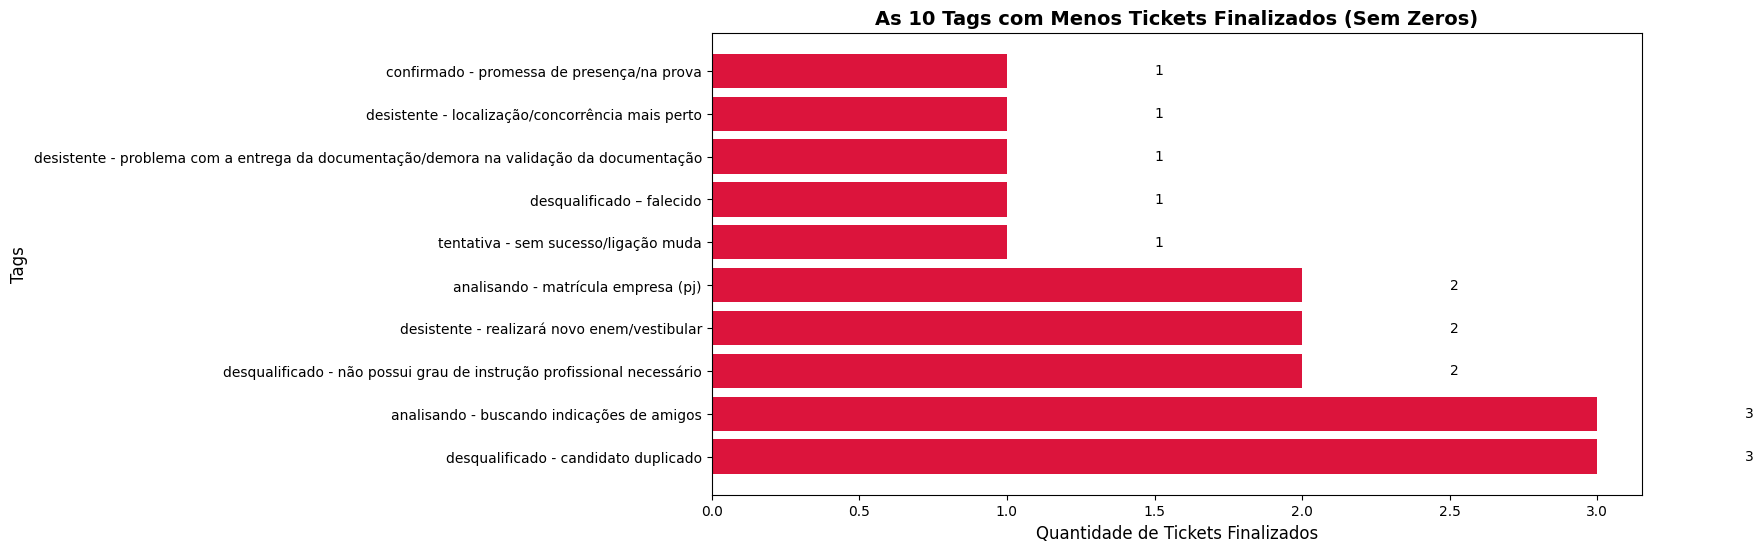

In [138]:
# Selecionando as 10 tags com menos tickets finalizados, excluindo valores zerados
bottom_tags_filtered = df[df['tickets_finalizados'] > 0].groupby('tag')['tickets_finalizados'].sum().nsmallest(10).reset_index()

# Criando o gráfico de barras horizontais para as tags menos frequentes
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(bottom_tags_filtered['tag'], bottom_tags_filtered['tickets_finalizados'], color='crimson')

# Adicionando os valores exatos ao lado das barras
for bar, value in zip(bars, bottom_tags_filtered['tickets_finalizados']):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f"{value}", va='center', fontsize=10)

# Ajustando rótulos e título
ax.set_xlabel("Quantidade de Tickets Finalizados", fontsize=12)
ax.set_ylabel("Tags", fontsize=12)
ax.set_title("As 10 Tags com Menos Tickets Finalizados (Sem Zeros)", fontsize=14, fontweight='bold')

# Revertendo a ordem para a mais relevante aparecer no topo
ax.invert_yaxis()

# Exibir o gráfico aprimorado
plt.show()

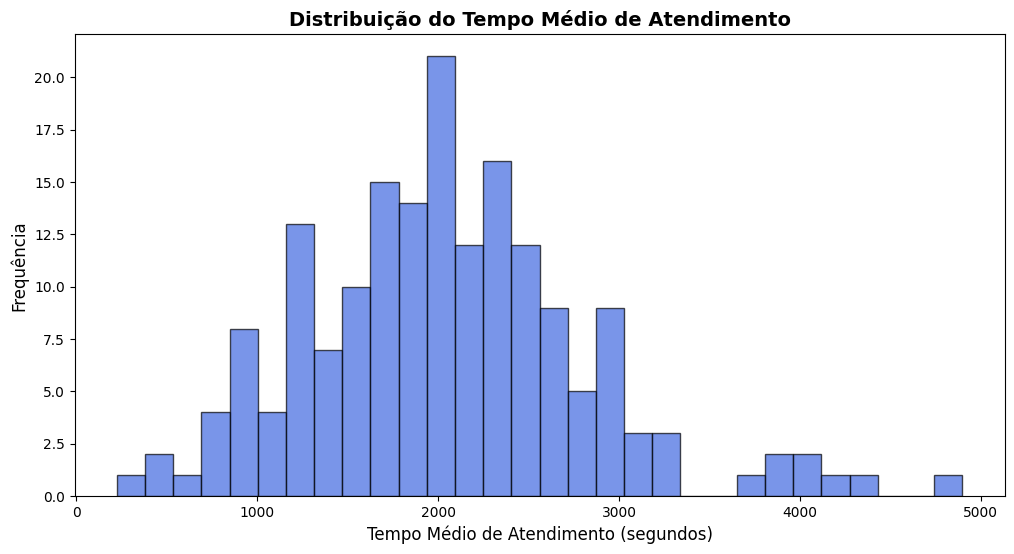

In [139]:
# Eliminando os registros com tempo médio de atendimento igual a zero
df_filtered = df[df['tempo_médio_de_atendimento'] > 0]

# Criando um histograma para visualizar a distribuição do tempo médio de atendimento
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(df_filtered['tempo_médio_de_atendimento'], bins=30, color='royalblue', edgecolor='black', alpha=0.7)

# Ajustando rótulos e título
ax.set_xlabel("Tempo Médio de Atendimento (segundos)", fontsize=12)
ax.set_ylabel("Frequência", fontsize=12)
ax.set_title("Distribuição do Tempo Médio de Atendimento", fontsize=14, fontweight='bold')

# Exibir o gráfico aprimorado
plt.show()


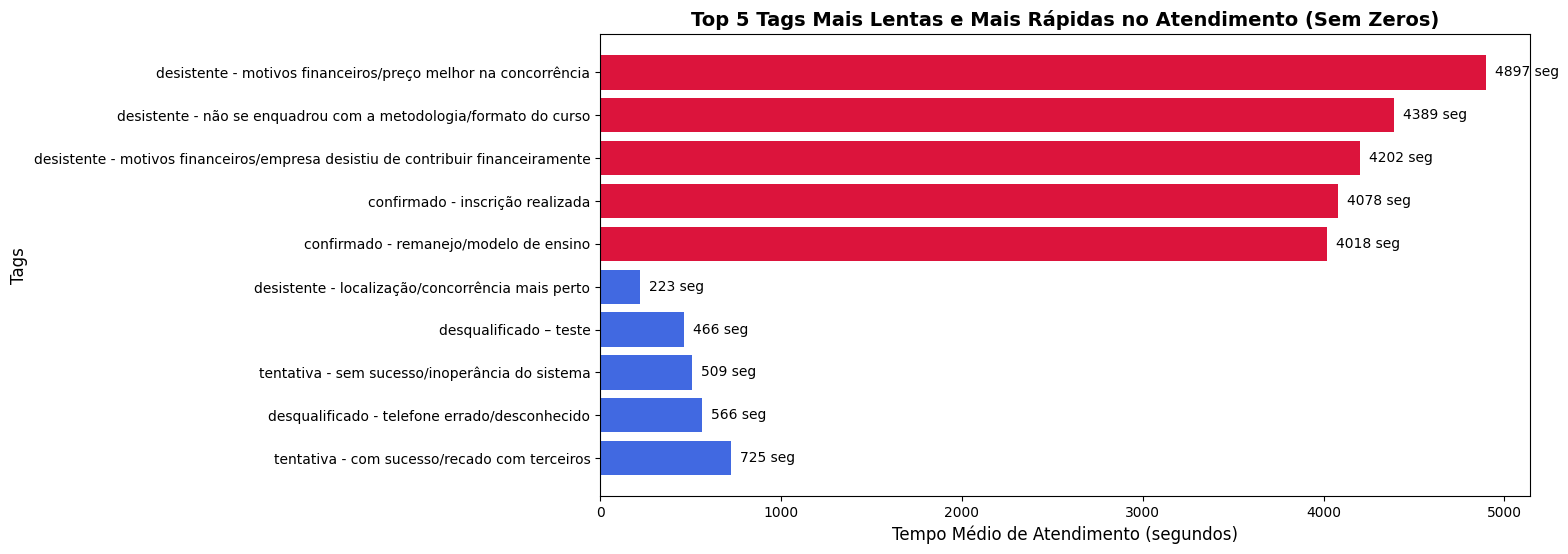

In [140]:
# Selecionando as 5 tags mais demoradas e as 5 mais rápidas após remover zeros
top_5_slowest = df_filtered.nlargest(5, 'tempo_médio_de_atendimento')[['tag', 'tempo_médio_de_atendimento']]
top_5_fastest = df_filtered.nsmallest(5, 'tempo_médio_de_atendimento')[['tag', 'tempo_médio_de_atendimento']]

# Criando um dataframe combinando as mais rápidas e mais lentas
top_slowest_fastest = pd.concat([top_5_slowest, top_5_fastest]).reset_index(drop=True)

# Criando um gráfico de barras para as 5 tags mais rápidas e 5 mais lentas
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(top_slowest_fastest['tag'], top_slowest_fastest['tempo_médio_de_atendimento'],
               color=['crimson' if i < 5 else 'royalblue' for i in range(10)])

# Adicionando os valores exatos ao lado das barras
for bar, value in zip(bars, top_slowest_fastest['tempo_médio_de_atendimento']):
    ax.text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2, f"{value} seg", va='center', fontsize=10)

# Ajustando rótulos e título
ax.set_xlabel("Tempo Médio de Atendimento (segundos)", fontsize=12)
ax.set_ylabel("Tags", fontsize=12)
ax.set_title("Top 5 Tags Mais Lentas e Mais Rápidas no Atendimento (Sem Zeros)", fontsize=14, fontweight='bold')

# Revertendo a ordem para a mais demorada aparecer no topo
ax.invert_yaxis()

# Exibir o gráfico aprimorado
plt.show()

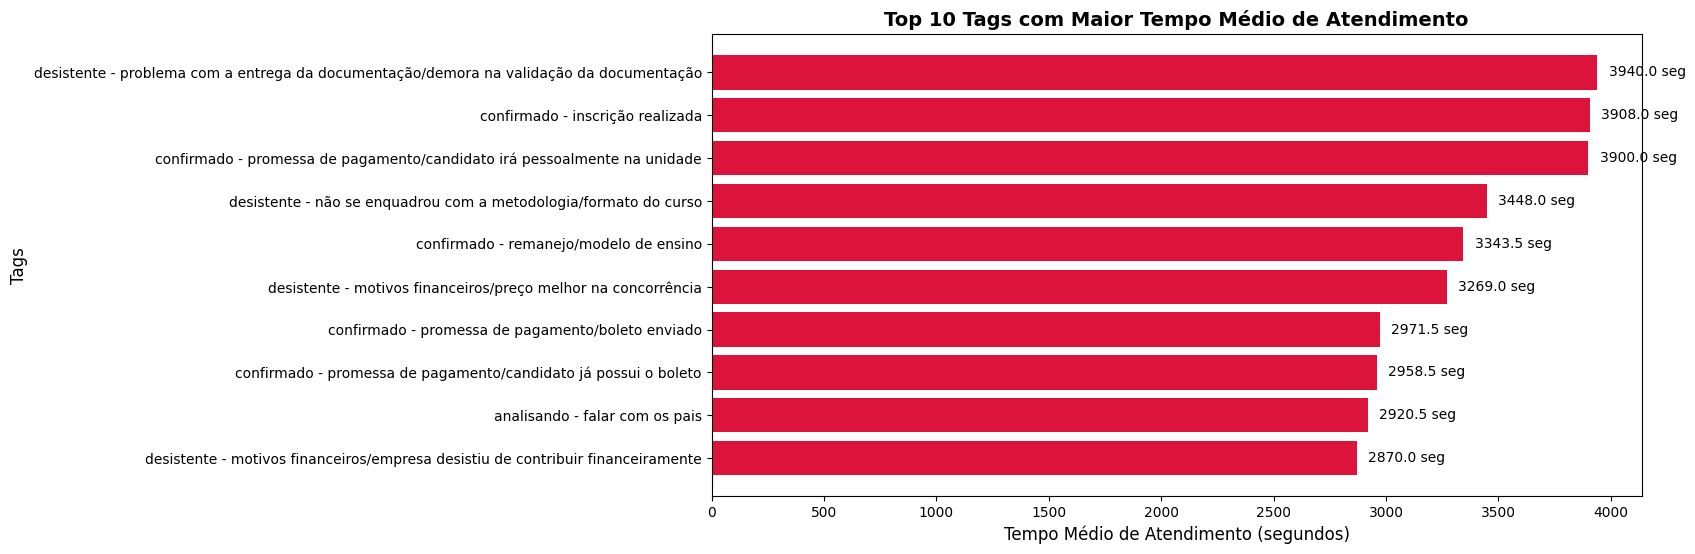

In [141]:
# Calculando a média do tempo de atendimento por tag
avg_time_per_tag = df_cleaned.groupby('tag')['tempo_médio_de_atendimento'].mean().reset_index()

# Selecionando as 10 tags com maior tempo médio de atendimento
top_slowest_tags = avg_time_per_tag.nlargest(10, 'tempo_médio_de_atendimento')

# Criando o gráfico de barras para as tags mais demoradas
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(top_slowest_tags['tag'], top_slowest_tags['tempo_médio_de_atendimento'], color='crimson')

# Adicionando os valores exatos ao lado das barras
for bar, value in zip(bars, top_slowest_tags['tempo_médio_de_atendimento']):
    ax.text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2, f"{value} seg", va='center', fontsize=10)

# Ajustando rótulos e título
ax.set_xlabel("Tempo Médio de Atendimento (segundos)", fontsize=12)
ax.set_ylabel("Tags", fontsize=12)
ax.set_title("Top 10 Tags com Maior Tempo Médio de Atendimento", fontsize=14, fontweight='bold')

# Revertendo a ordem para a mais demorada aparecer no topo
ax.invert_yaxis()

# Exibir o gráfico aprimorado
plt.show()

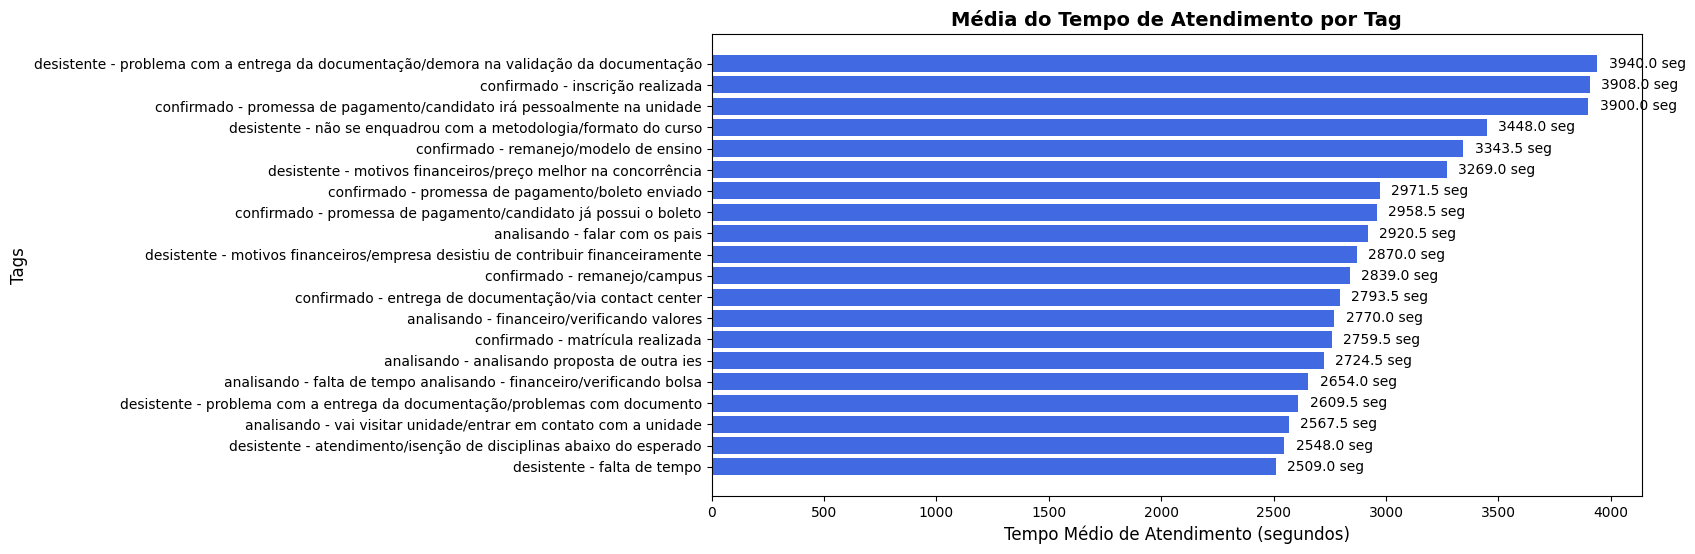

In [142]:
# Criando o gráfico de barras para a média do tempo de atendimento por tag

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(avg_time_per_tag.nlargest(20, 'tempo_médio_de_atendimento')['tag'],
               avg_time_per_tag.nlargest(20, 'tempo_médio_de_atendimento')['tempo_médio_de_atendimento'],
               color='royalblue')

# Adicionando os valores exatos ao lado das barras
for bar, value in zip(bars, avg_time_per_tag.nlargest(20, 'tempo_médio_de_atendimento')['tempo_médio_de_atendimento']):
    ax.text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2, f"{value:.1f} seg", va='center', fontsize=10)

# Ajustando rótulos e título
ax.set_xlabel("Tempo Médio de Atendimento (segundos)", fontsize=12)
ax.set_ylabel("Tags", fontsize=12)
ax.set_title("Média do Tempo de Atendimento por Tag", fontsize=14, fontweight='bold')

# Revertendo a ordem para a mais demorada aparecer no topo
ax.invert_yaxis()

# Exibir o gráfico aprimorado
plt.show()


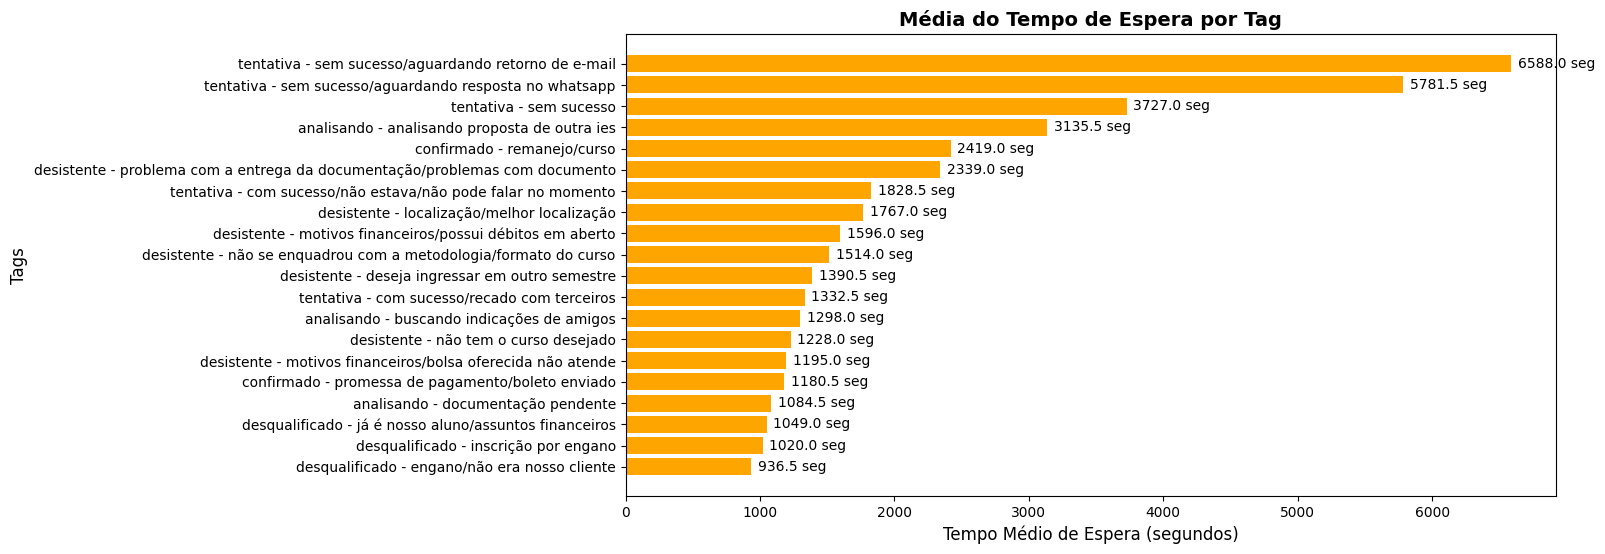

In [143]:
# Calculando a média do tempo de espera por tag
avg_wait_time_per_tag = df_cleaned.groupby('tag')['tempo_médio_de_espera'].mean().reset_index()

# Selecionando as 20 tags com maior tempo médio de espera
top_waiting_tags = avg_wait_time_per_tag.nlargest(20, 'tempo_médio_de_espera')

# Criando o gráfico de barras para a média do tempo de espera por tag
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(top_waiting_tags['tag'], top_waiting_tags['tempo_médio_de_espera'], color='orange')

# Adicionando os valores exatos ao lado das barras
for bar, value in zip(bars, top_waiting_tags['tempo_médio_de_espera']):
    ax.text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2, f"{value:.1f} seg", va='center', fontsize=10)

# Ajustando rótulos e título
ax.set_xlabel("Tempo Médio de Espera (segundos)", fontsize=12)
ax.set_ylabel("Tags", fontsize=12)
ax.set_title("Média do Tempo de Espera por Tag", fontsize=14, fontweight='bold')

# Revertendo a ordem para a mais demorada aparecer no topo
ax.invert_yaxis()

# Exibir o gráfico aprimorado
plt.show()

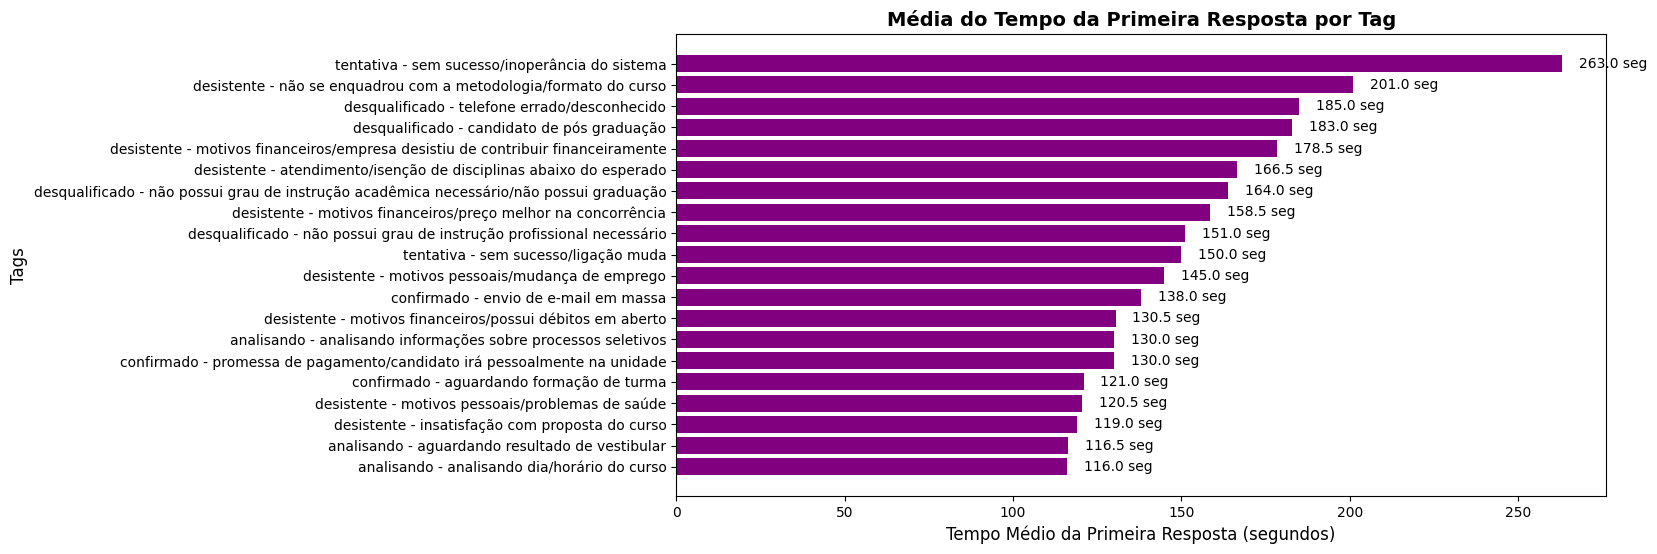

In [145]:
# Calculando a média do tempo da primeira resposta por tag
avg_first_response_time_per_tag = df_cleaned.groupby('tag')['tempo_médio_da_1ª_resposta'].mean().reset_index()

# Selecionando as 20 tags com maior tempo médio de primeira resposta
top_first_response_tags = avg_first_response_time_per_tag.nlargest(20, 'tempo_médio_da_1ª_resposta')

# Criando o gráfico de barras para a média do tempo da primeira resposta por tag
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(top_first_response_tags['tag'], top_first_response_tags['tempo_médio_da_1ª_resposta'], color='purple')

# Adicionando os valores exatos ao lado das barras
for bar, value in zip(bars, top_first_response_tags['tempo_médio_da_1ª_resposta']):
    ax.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, f"{value:.1f} seg", va='center', fontsize=10)

# Ajustando rótulos e título
ax.set_xlabel("Tempo Médio da Primeira Resposta (segundos)", fontsize=12)
ax.set_ylabel("Tags", fontsize=12)
ax.set_title("Média do Tempo da Primeira Resposta por Tag", fontsize=14, fontweight='bold')

# Revertendo a ordem para a mais demorada aparecer no topo
ax.invert_yaxis()

# Exibir o gráfico aprimorado
plt.show()

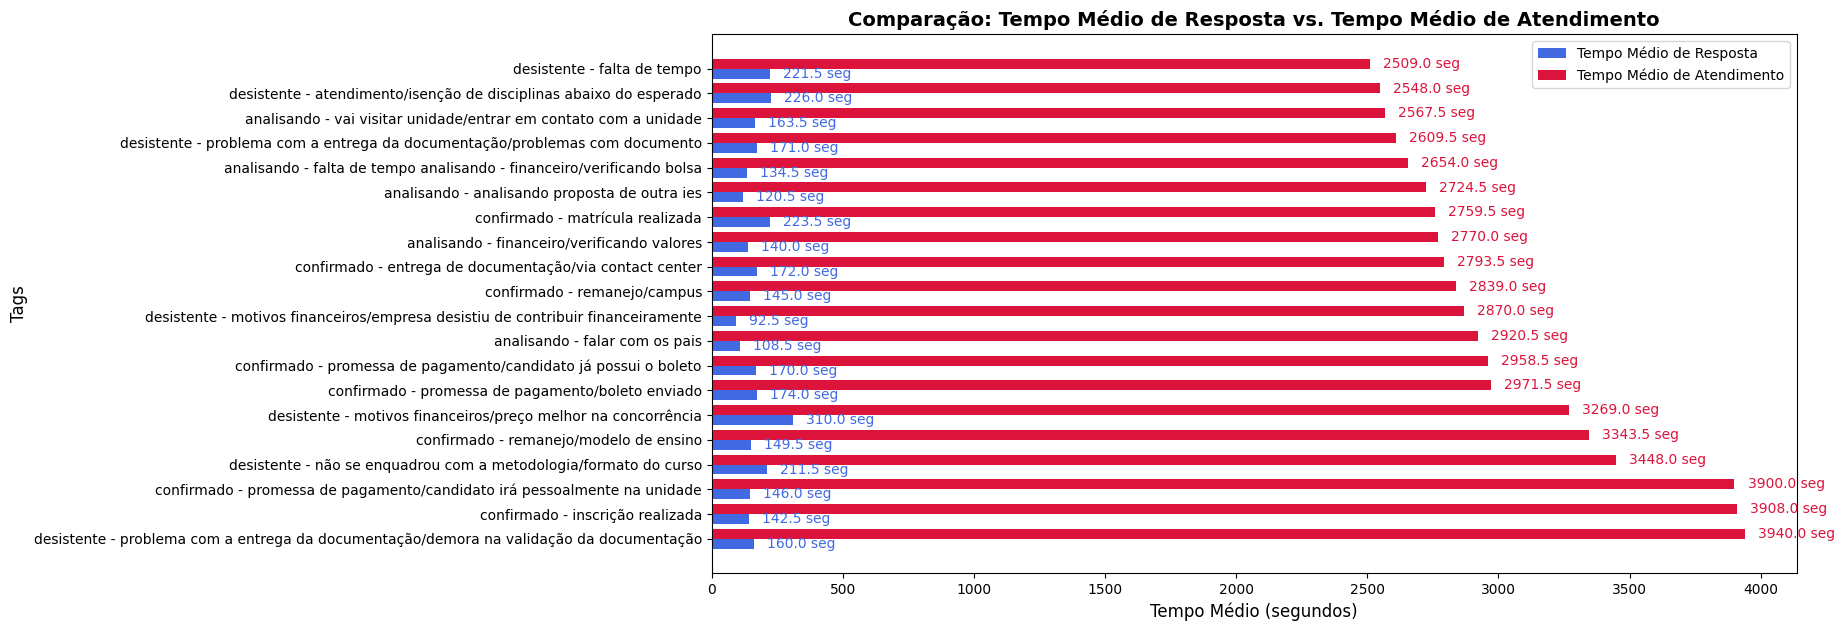

In [146]:
# Criando um dataframe comparativo entre tempo médio de resposta e tempo médio de atendimento por tag
avg_response_vs_attendance = df_cleaned.groupby('tag')[['tempo_médio_de_resposta', 'tempo_médio_de_atendimento']].mean().reset_index()

# Selecionando as 20 tags com maior tempo médio de atendimento para melhor comparação
top_tags_comparison = avg_response_vs_attendance.nlargest(20, 'tempo_médio_de_atendimento')

# Criando o gráfico de barras lado a lado para comparar tempo médio de resposta e atendimento
fig, ax = plt.subplots(figsize=(14, 7))
bar_width = 0.4
indices = range(len(top_tags_comparison))

# Barras para tempo médio de resposta
bars1 = ax.barh([i - bar_width/2 for i in indices], top_tags_comparison['tempo_médio_de_resposta'],
                bar_width, label="Tempo Médio de Resposta", color='royalblue')

# Barras para tempo médio de atendimento
bars2 = ax.barh([i + bar_width/2 for i in indices], top_tags_comparison['tempo_médio_de_atendimento'],
                bar_width, label="Tempo Médio de Atendimento", color='crimson')

# Adicionando os valores exatos ao lado das barras
for bar1, bar2, value1, value2 in zip(bars1, bars2, top_tags_comparison['tempo_médio_de_resposta'], top_tags_comparison['tempo_médio_de_atendimento']):
    ax.text(bar1.get_width() + 50, bar1.get_y() + bar1.get_height()/2, f"{value1:.1f} seg", va='center', fontsize=10, color='royalblue')
    ax.text(bar2.get_width() + 50, bar2.get_y() + bar2.get_height()/2, f"{value2:.1f} seg", va='center', fontsize=10, color='crimson')

# Ajustando rótulos e título
ax.set_xlabel("Tempo Médio (segundos)", fontsize=12)
ax.set_ylabel("Tags", fontsize=12)
ax.set_title("Comparação: Tempo Médio de Resposta vs. Tempo Médio de Atendimento", fontsize=14, fontweight='bold')

# Ajustando os rótulos do eixo Y
ax.set_yticks(indices)
ax.set_yticklabels(top_tags_comparison['tag'])

# Adicionando a legenda
ax.legend()

# Exibir o gráfico aprimorado
plt.show()

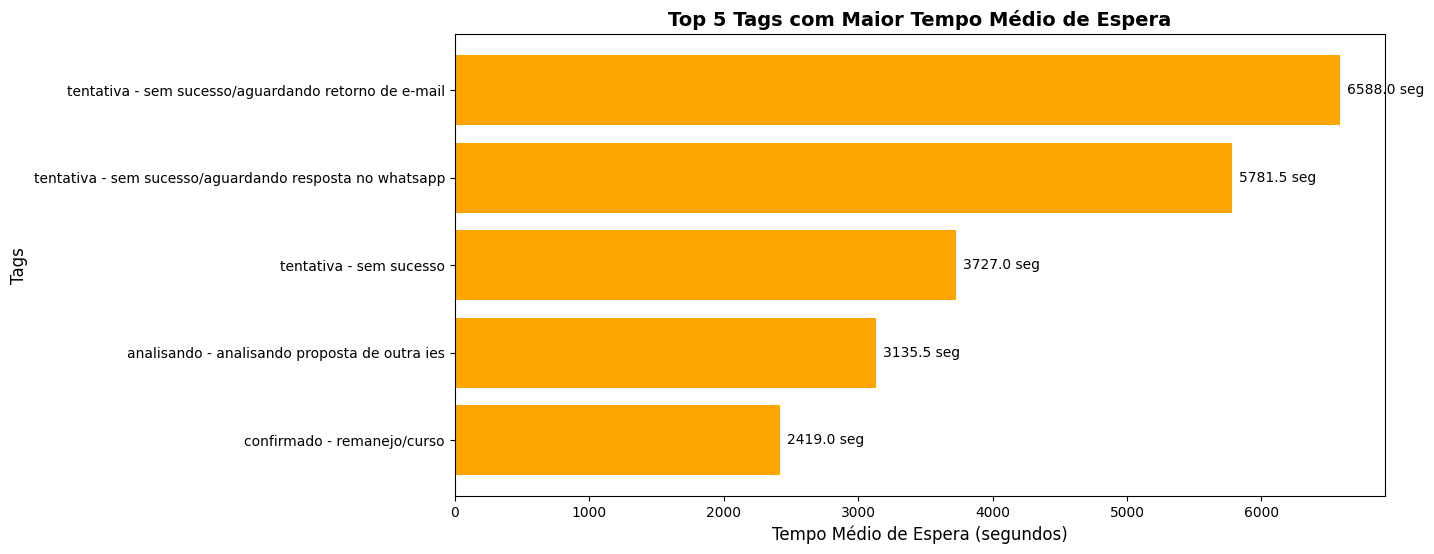

In [147]:
# Selecionando as 5 tags com maior tempo médio de espera
top_5_waiting_tags = avg_wait_time_per_tag.nlargest(5, 'tempo_médio_de_espera')

# Criando o gráfico de barras para as 5 tags com maior tempo médio de espera
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(top_5_waiting_tags['tag'], top_5_waiting_tags['tempo_médio_de_espera'], color='orange')

# Adicionando os valores exatos ao lado das barras
for bar, value in zip(bars, top_5_waiting_tags['tempo_médio_de_espera']):
    ax.text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2, f"{value:.1f} seg", va='center', fontsize=10)

# Ajustando rótulos e título
ax.set_xlabel("Tempo Médio de Espera (segundos)", fontsize=12)
ax.set_ylabel("Tags", fontsize=12)
ax.set_title("Top 5 Tags com Maior Tempo Médio de Espera", fontsize=14, fontweight='bold')

# Revertendo a ordem para a mais demorada aparecer no topo
ax.invert_yaxis()

# Exibir o gráfico aprimorado
plt.show()

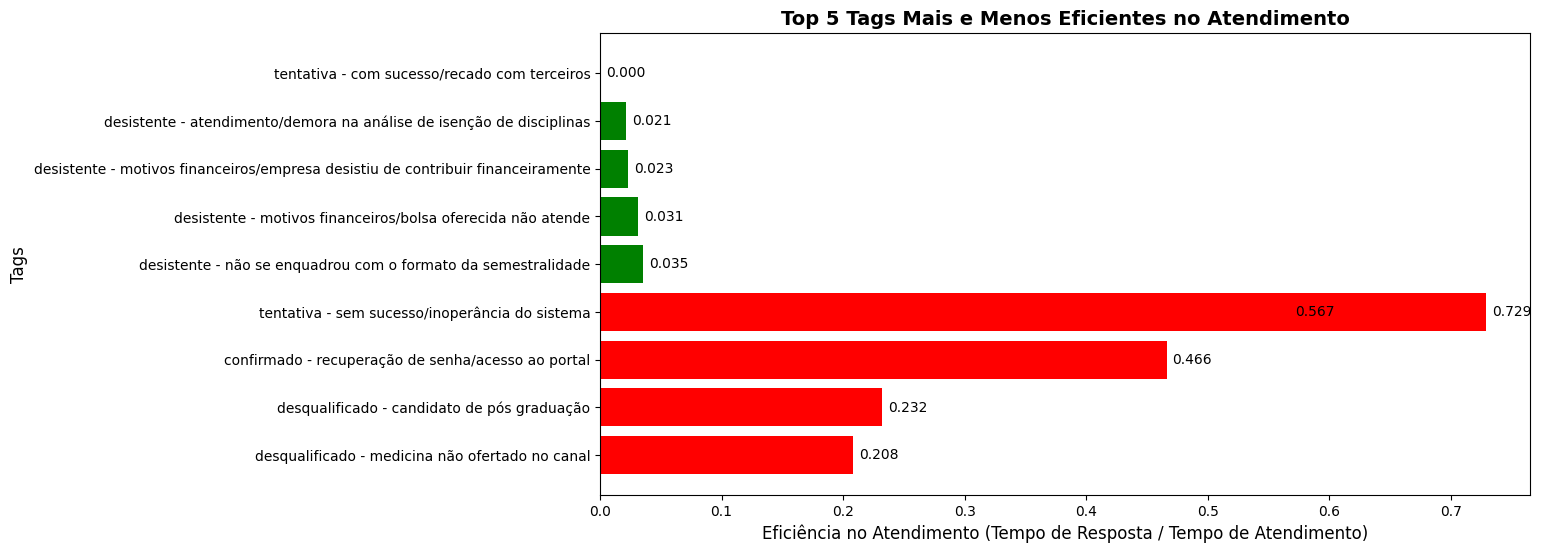

In [148]:
# Calculando a eficiência no atendimento como a relação entre tempo médio de resposta e tempo médio de atendimento
df_cleaned['eficiencia_atendimento'] = df_cleaned['tempo_médio_de_resposta'] / df_cleaned['tempo_médio_de_atendimento']

# Removendo valores infinitos ou nulos
df_efficiency = df_cleaned[['tag', 'tempo_médio_de_resposta', 'tempo_médio_de_atendimento', 'eficiencia_atendimento']].dropna()
df_efficiency = df_efficiency.replace([float('inf'), -float('inf')], 0)

# Selecionando as 10 tags mais e menos eficientes
top_5_most_efficient = df_efficiency.nsmallest(5, 'eficiencia_atendimento')  # Menor relação = mais eficiente
top_5_least_efficient = df_efficiency.nlargest(5, 'eficiencia_atendimento')  # Maior relação = menos eficiente

# Combinando as duas listas para exibição
top_efficiency = pd.concat([top_5_most_efficient, top_5_least_efficient])

# Criando um gráfico de barras para visualizar as tags mais e menos eficientes
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(top_efficiency['tag'], top_efficiency['eficiencia_atendimento'],
               color=['green' if i < 5 else 'red' for i in range(10)])

# Adicionando os valores exatos ao lado das barras
for bar, value in zip(bars, top_efficiency['eficiencia_atendimento']):
    ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, f"{value:.3f}", va='center', fontsize=10)

# Ajustando rótulos e título
ax.set_xlabel("Eficiência no Atendimento (Tempo de Resposta / Tempo de Atendimento)", fontsize=12)
ax.set_ylabel("Tags", fontsize=12)
ax.set_title("Top 5 Tags Mais e Menos Eficientes no Atendimento", fontsize=14, fontweight='bold')

# Revertendo a ordem para melhor visualização
ax.invert_yaxis()

# Exibir o gráfico aprimorado
plt.show()

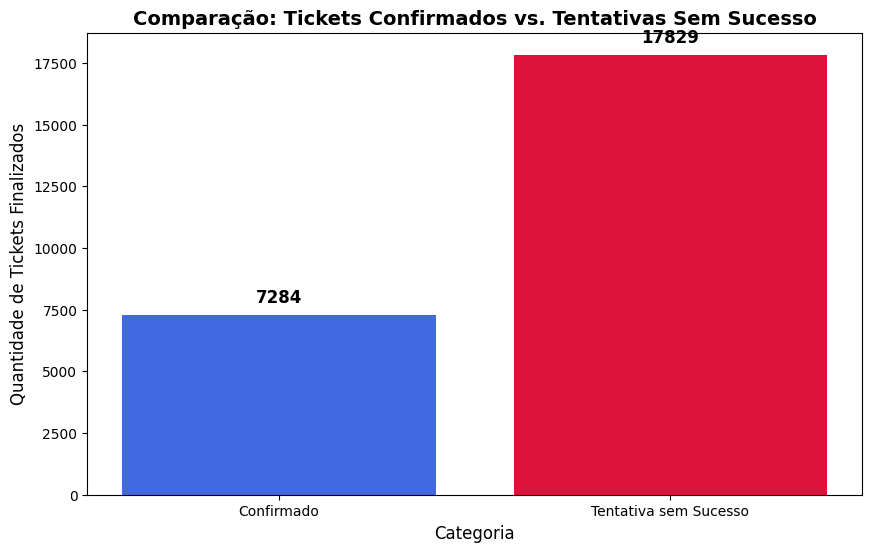

In [149]:
# Agrupando as tags em duas categorias principais: "Confirmado" e "Tentativa sem Sucesso"
df_cleaned['categoria_atendimento'] = df_cleaned['tag'].apply(lambda x:
    'Confirmado' if 'confirmado' in x else ('Tentativa sem Sucesso' if 'tentativa - sem sucesso' in x else 'Outros'))

# Filtrando apenas as categorias "Confirmado" e "Tentativa sem Sucesso"
df_category_comparison = df_cleaned[df_cleaned['categoria_atendimento'].isin(['Confirmado', 'Tentativa sem Sucesso'])]

# Calculando o volume total de tickets por categoria
tickets_comparison = df_category_comparison.groupby('categoria_atendimento')['tickets_finalizados'].sum().reset_index()

# Criando o gráfico de barras para comparar o volume de tickets entre as categorias
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(tickets_comparison['categoria_atendimento'], tickets_comparison['tickets_finalizados'], color=['royalblue', 'crimson'])

# Adicionando os valores exatos no topo das barras
for bar, value in zip(bars, tickets_comparison['tickets_finalizados']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500, f"{value}", ha='center', fontsize=12, fontweight='bold')

# Ajustando rótulos e título
ax.set_xlabel("Categoria", fontsize=12)
ax.set_ylabel("Quantidade de Tickets Finalizados", fontsize=12)
ax.set_title("Comparação: Tickets Confirmados vs. Tentativas Sem Sucesso", fontsize=14, fontweight='bold')

# Exibir o gráfico aprimorado
plt.show()

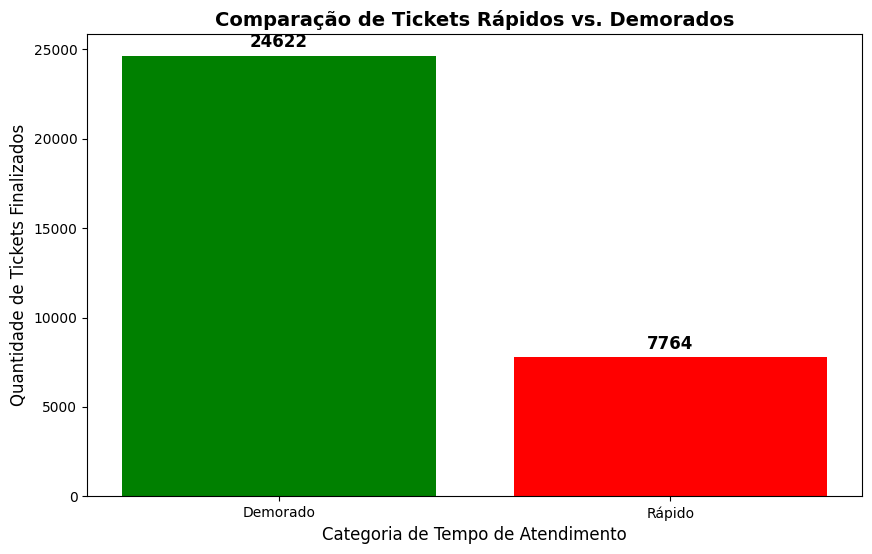

In [150]:
# Definir o critério para tickets "rápidos" e "demorados"
# Utilizando a média geral do tempo médio de atendimento como referência
average_attendance_time = df_cleaned['tempo_médio_de_atendimento'].mean()

# Criando uma nova coluna para classificar os atendimentos
df_cleaned['categoria_tempo_atendimento'] = df_cleaned['tempo_médio_de_atendimento'].apply(
    lambda x: 'Rápido' if x < average_attendance_time else 'Demorado'
)

# Contagem de tickets por categoria de tempo de atendimento
tickets_by_time_category = df_cleaned.groupby('categoria_tempo_atendimento')['tickets_finalizados'].sum().reset_index()

# Criando o gráfico de barras comparando tickets rápidos e demorados
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(tickets_by_time_category['categoria_tempo_atendimento'],
              tickets_by_time_category['tickets_finalizados'], color=['green', 'red'])

# Adicionando os valores exatos no topo das barras
for bar, value in zip(bars, tickets_by_time_category['tickets_finalizados']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500, f"{value}", ha='center', fontsize=12, fontweight='bold')

# Ajustando rótulos e título
ax.set_xlabel("Categoria de Tempo de Atendimento", fontsize=12)
ax.set_ylabel("Quantidade de Tickets Finalizados", fontsize=12)
ax.set_title("Comparação de Tickets Rápidos vs. Demorados", fontsize=14, fontweight='bold')

# Exibir o gráfico aprimorado
plt.show()

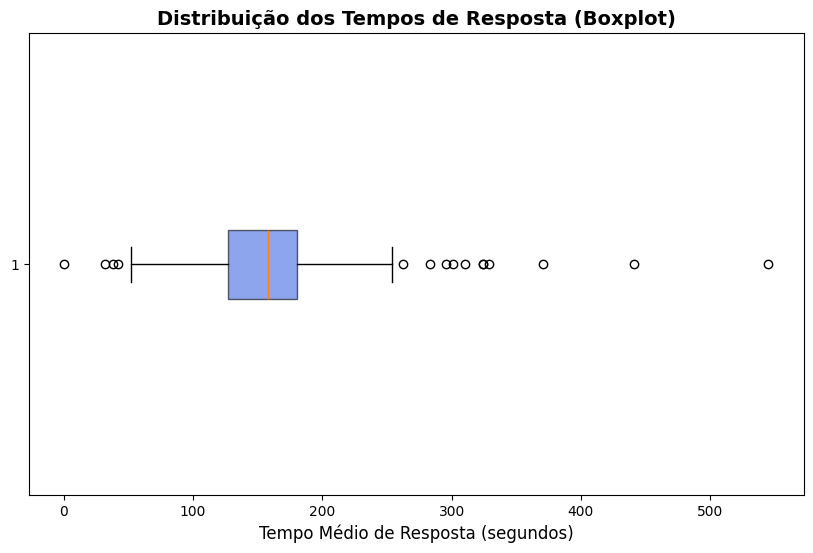

In [151]:
# Calculando os quartis do tempo médio de resposta
quartiles = df_cleaned['tempo_médio_de_resposta'].quantile([0.25, 0.5, 0.75]).to_frame().reset_index()
quartiles.columns = ['Percentil', 'Tempo Médio de Resposta (segundos)']
quartiles['Percentil'] = quartiles['Percentil'].apply(lambda x: f"{int(x * 100)}%")

# Criando um boxplot para visualizar a dispersão dos tempos de resposta
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(df_cleaned['tempo_médio_de_resposta'], vert=False, patch_artist=True, boxprops=dict(facecolor='royalblue', alpha=0.6))

# Ajustando rótulos e título
ax.set_xlabel("Tempo Médio de Resposta (segundos)", fontsize=12)
ax.set_title("Distribuição dos Tempos de Resposta (Boxplot)", fontsize=14, fontweight='bold')

# Exibir o boxplot
plt.show()

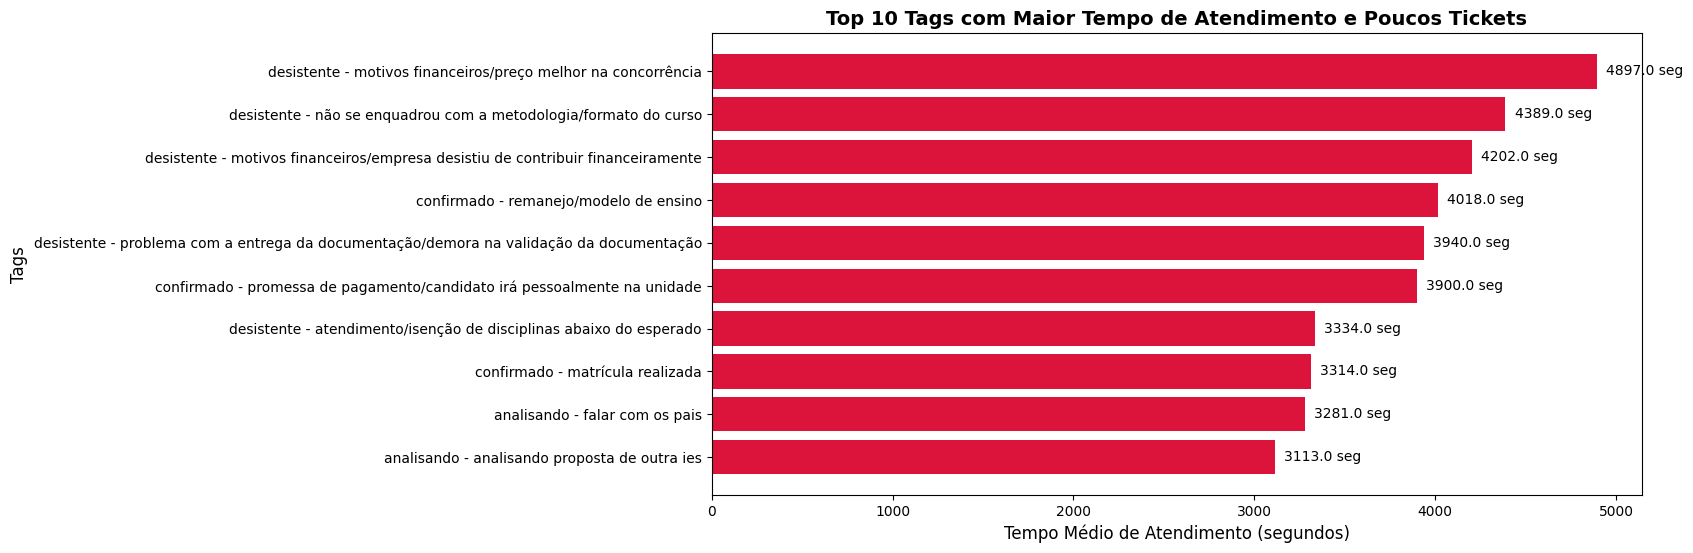

In [155]:
# Recalculando as tags com alto tempo médio de atendimento e poucos tickets
average_attendance_time = df_cleaned['tempo_médio_de_atendimento'].mean()
average_tickets = df_cleaned['tickets_finalizados'].mean()

# Filtrando tags que possuem alto tempo médio de atendimento, mas poucos tickets
high_time_low_tickets = df_cleaned[(df_cleaned['tempo_médio_de_atendimento'] > average_attendance_time) &
                                   (df_cleaned['tickets_finalizados'] < average_tickets)][['tag', 'tickets_finalizados', 'tempo_médio_de_atendimento']]

# Ordenando pelo maior tempo de atendimento
high_time_low_tickets = high_time_low_tickets.sort_values(by='tempo_médio_de_atendimento', ascending=False)

# Selecionando as 10 tags com maior tempo médio de atendimento e poucos tickets
top_10_high_time_low_tickets = high_time_low_tickets.nlargest(10, 'tempo_médio_de_atendimento')

# Selecionando as 10 tags com menor tempo médio de atendimento e poucos tickets
bottom_10_high_time_low_tickets = high_time_low_tickets.nsmallest(10, 'tempo_médio_de_atendimento')

# Criando o gráfico de barras para as 10 tags com maior tempo de atendimento e poucos tickets
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(top_10_high_time_low_tickets['tag'], top_10_high_time_low_tickets['tempo_médio_de_atendimento'], color='crimson')

# Adicionando os valores exatos ao lado das barras
for bar, value in zip(bars, top_10_high_time_low_tickets['tempo_médio_de_atendimento']):
    ax.text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2, f"{value:.1f} seg", va='center', fontsize=10)

# Ajustando rótulos e título
ax.set_xlabel("Tempo Médio de Atendimento (segundos)", fontsize=12)
ax.set_ylabel("Tags", fontsize=12)
ax.set_title("Top 10 Tags com Maior Tempo de Atendimento e Poucos Tickets", fontsize=14, fontweight='bold')

# Revertendo a ordem para a mais demorada aparecer no topo
ax.invert_yaxis()

# Exibir o gráfico aprimorado
plt.show()



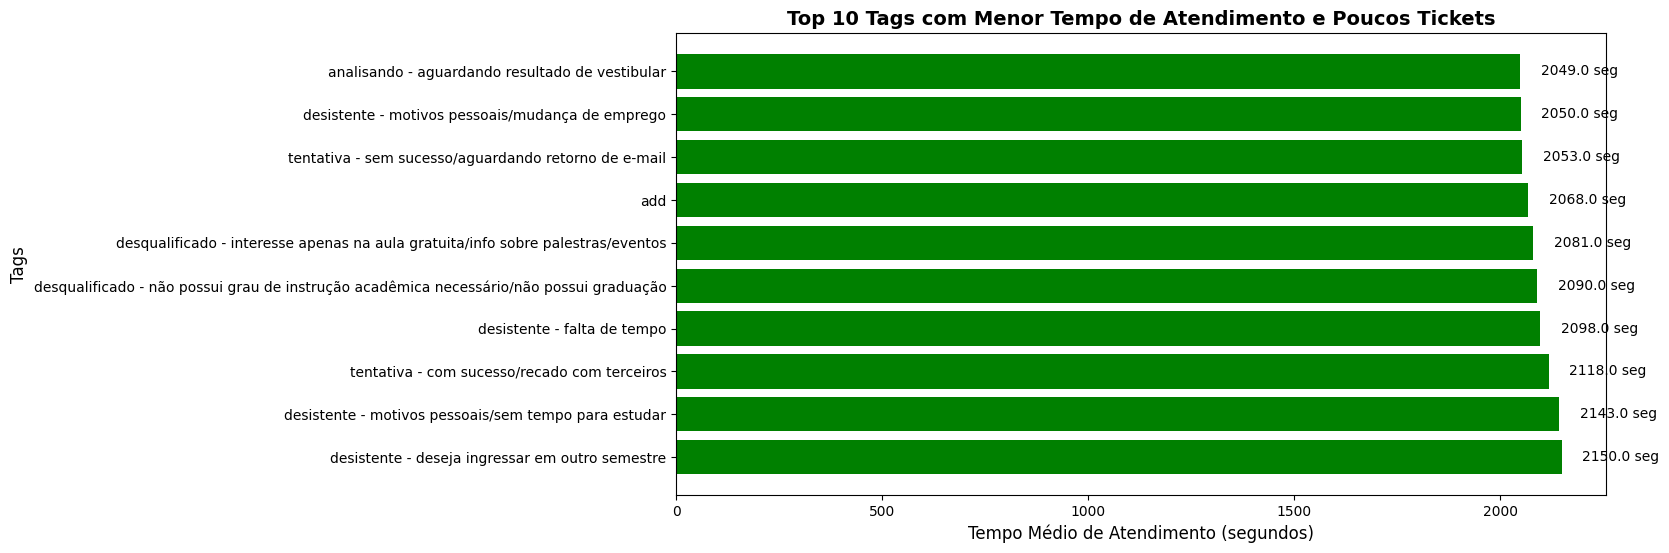

In [156]:
# Criando o gráfico de barras para as 10 tags com menor tempo de atendimento e poucos tickets
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(bottom_10_high_time_low_tickets['tag'], bottom_10_high_time_low_tickets['tempo_médio_de_atendimento'], color='green')

# Adicionando os valores exatos ao lado das barras
for bar, value in zip(bars, bottom_10_high_time_low_tickets['tempo_médio_de_atendimento']):
    ax.text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2, f"{value:.1f} seg", va='center', fontsize=10)

# Ajustando rótulos e título
ax.set_xlabel("Tempo Médio de Atendimento (segundos)", fontsize=12)
ax.set_ylabel("Tags", fontsize=12)
ax.set_title("Top 10 Tags com Menor Tempo de Atendimento e Poucos Tickets", fontsize=14, fontweight='bold')

# Revertendo a ordem para a mais rápida aparecer no topo
ax.invert_yaxis()

# Exibir o gráfico aprimorado
plt.show()


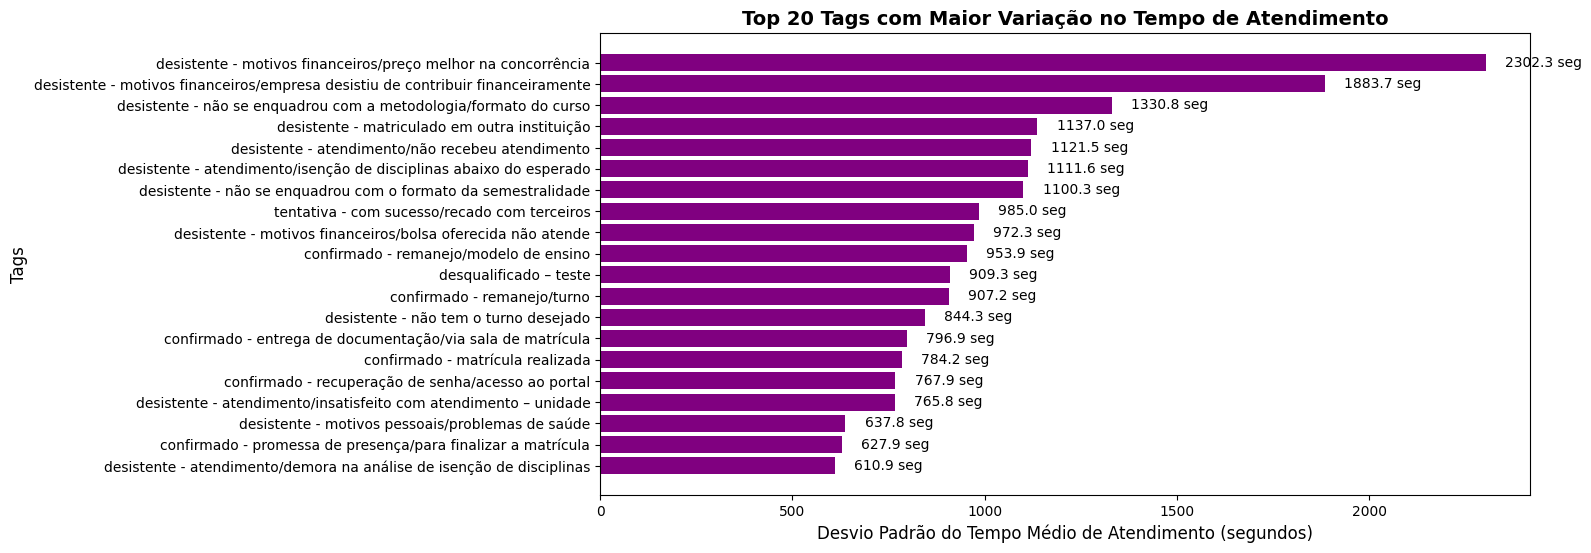

In [158]:
# Calculando o desvio padrão do tempo médio de atendimento por tag
std_dev_per_tag = df_cleaned.groupby('tag')['tempo_médio_de_atendimento'].std().reset_index()

# Removendo valores nulos e ordenando pelas tags com maior variação
std_dev_per_tag = std_dev_per_tag.dropna().sort_values(by='tempo_médio_de_atendimento', ascending=False)

# Selecionando as 20 tags com maior variação
top_20_variability = std_dev_per_tag.nlargest(20, 'tempo_médio_de_atendimento')

# Criando um gráfico de barras para mostrar a variabilidade no tempo de atendimento
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(top_20_variability['tag'], top_20_variability['tempo_médio_de_atendimento'], color='purple')

# Adicionando os valores exatos ao lado das barras
for bar, value in zip(bars, top_20_variability['tempo_médio_de_atendimento']):
    ax.text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2, f"{value:.1f} seg", va='center', fontsize=10)

# Ajustando rótulos e título
ax.set_xlabel("Desvio Padrão do Tempo Médio de Atendimento (segundos)", fontsize=12)
ax.set_ylabel("Tags", fontsize=12)
ax.set_title("Top 20 Tags com Maior Variação no Tempo de Atendimento", fontsize=14, fontweight='bold')

# Revertendo a ordem para a mais variável aparecer no topo
ax.invert_yaxis()

# Exibir o gráfico aprimorado
plt.show()

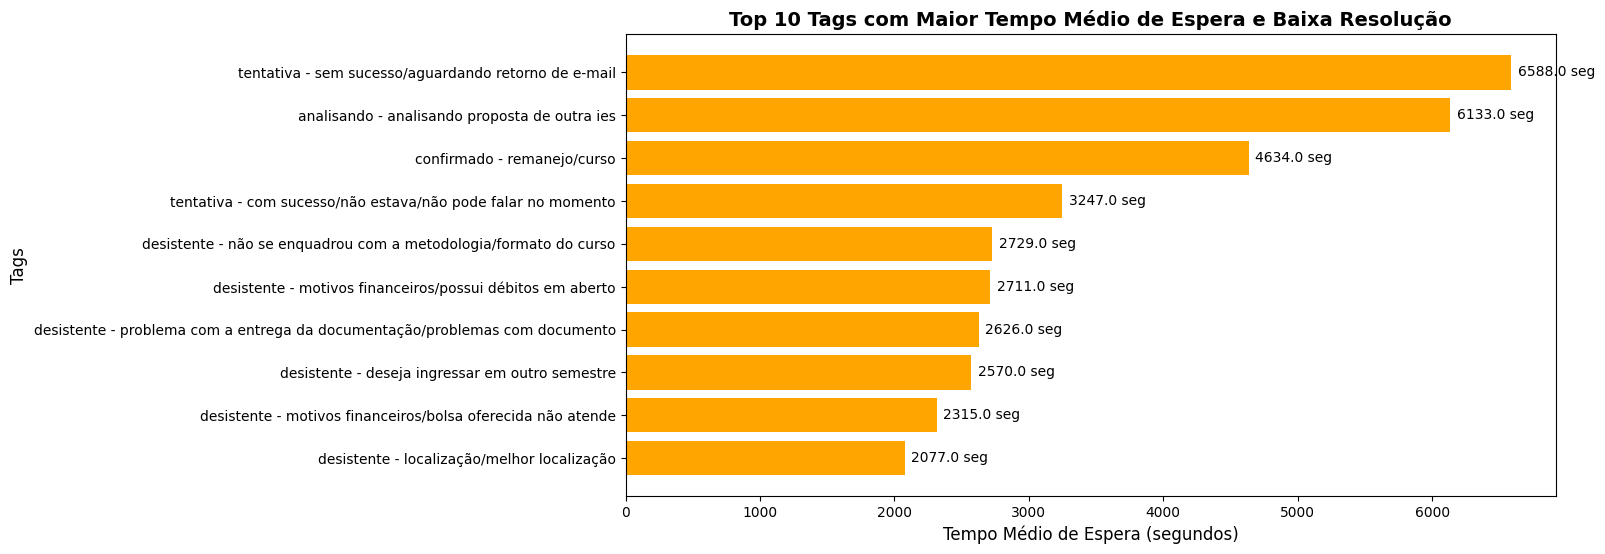

In [159]:
# Definir critérios: alto tempo médio de espera e baixa resolução (poucos tickets finalizados)
average_wait_time = df_cleaned['tempo_médio_de_espera'].mean()
average_tickets = df_cleaned['tickets_finalizados'].mean()

# Filtrar tags com alto tempo médio de espera e poucos tickets finalizados
high_wait_low_resolution = df_cleaned[(df_cleaned['tempo_médio_de_espera'] > average_wait_time) &
                                      (df_cleaned['tickets_finalizados'] < average_tickets)][['tag', 'tickets_finalizados', 'tempo_médio_de_espera']]

# Ordenando pelo maior tempo médio de espera
high_wait_low_resolution = high_wait_low_resolution.sort_values(by='tempo_médio_de_espera', ascending=False)

# Selecionando as 10 tags com maior tempo médio de espera e baixa resolução
top_10_high_wait_low_res = high_wait_low_resolution.nlargest(10, 'tempo_médio_de_espera')

# Criando um gráfico de barras comparativo
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(top_10_high_wait_low_res['tag'], top_10_high_wait_low_res['tempo_médio_de_espera'], color='orange')

# Adicionando os valores exatos ao lado das barras
for bar, value in zip(bars, top_10_high_wait_low_res['tempo_médio_de_espera']):
    ax.text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2, f"{value:.1f} seg", va='center', fontsize=10)

# Ajustando rótulos e título
ax.set_xlabel("Tempo Médio de Espera (segundos)", fontsize=12)
ax.set_ylabel("Tags", fontsize=12)
ax.set_title("Top 10 Tags com Maior Tempo Médio de Espera e Baixa Resolução", fontsize=14, fontweight='bold')

# Revertendo a ordem para melhor visualização
ax.invert_yaxis()

# Exibir o gráfico aprimorado
plt.show()

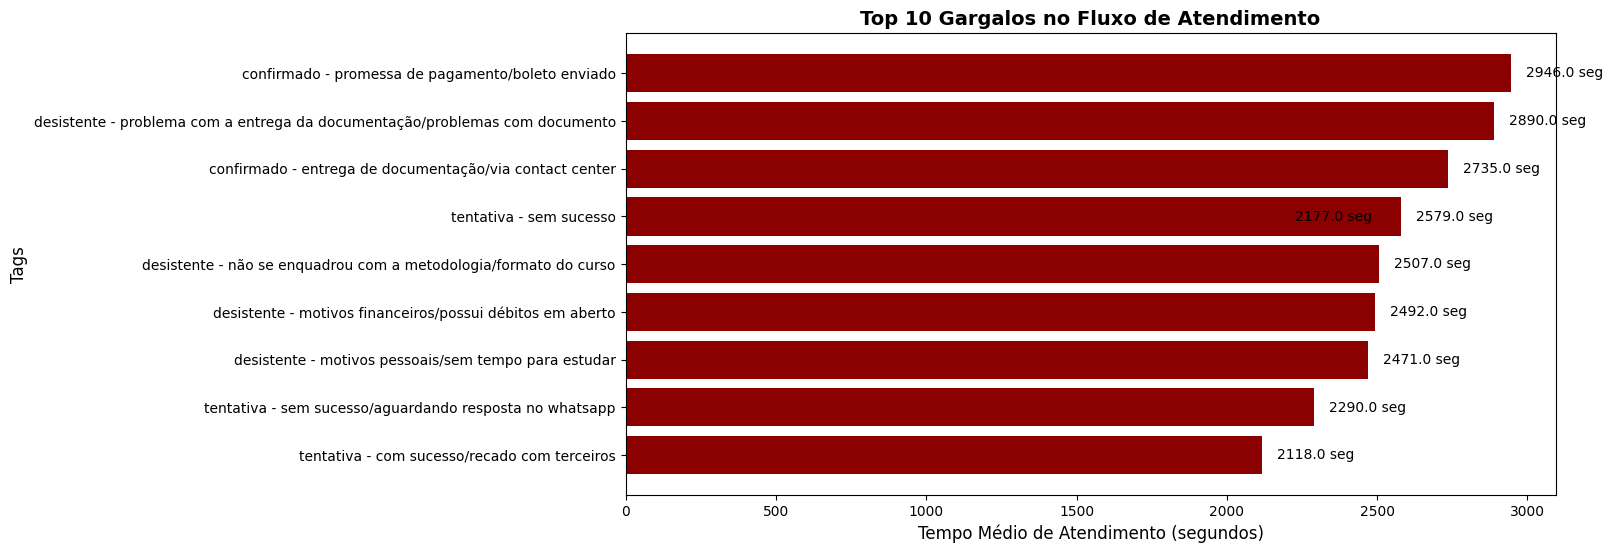

In [160]:
# Identificando gargalos no fluxo de atendimento com base nos tempos médios
# Critérios: Alto tempo médio de espera, resposta e atendimento
average_wait_time = df_cleaned['tempo_médio_de_espera'].mean()
average_response_time = df_cleaned['tempo_médio_de_resposta'].mean()
average_attendance_time = df_cleaned['tempo_médio_de_atendimento'].mean()

# Filtrando tags com alto tempo médio de espera, resposta e atendimento
bottlenecks = df_cleaned[(df_cleaned['tempo_médio_de_espera'] > average_wait_time) &
                         (df_cleaned['tempo_médio_de_resposta'] > average_response_time) &
                         (df_cleaned['tempo_médio_de_atendimento'] > average_attendance_time)][['tag',
                         'tempo_médio_de_espera', 'tempo_médio_de_resposta', 'tempo_médio_de_atendimento']]

# Ordenando pelos atendimentos mais demorados
bottlenecks = bottlenecks.sort_values(by='tempo_médio_de_atendimento', ascending=False)

# Selecionando as 10 tags com maiores gargalos no fluxo de atendimento
top_10_bottlenecks = bottlenecks.nlargest(10, 'tempo_médio_de_atendimento')

# Criando um gráfico de barras para os gargalos identificados
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(top_10_bottlenecks['tag'], top_10_bottlenecks['tempo_médio_de_atendimento'], color='darkred')

# Adicionando os valores exatos ao lado das barras
for bar, value in zip(bars, top_10_bottlenecks['tempo_médio_de_atendimento']):
    ax.text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2, f"{value:.1f} seg", va='center', fontsize=10)

# Ajustando rótulos e título
ax.set_xlabel("Tempo Médio de Atendimento (segundos)", fontsize=12)
ax.set_ylabel("Tags", fontsize=12)
ax.set_title("Top 10 Gargalos no Fluxo de Atendimento", fontsize=14, fontweight='bold')

# Revertendo a ordem para melhor visualização
ax.invert_yaxis()

# Exibir o gráfico aprimorado
plt.show()